In [1]:
#%matplotlib inline

import pandas as pd
import numpy as np

import xarray as xr

import regionmask

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import feather, h5py, sys, pickle
from shapely.geometry import Point, Polygon
#from geocube.api.core import make_geocube
import xagg as xa
import netCDF4
import geopandas
import feather 
import cmocean
import scipy

import sys
sys.path.append('../')
import utils
import plotting

import difflib 

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

In [2]:
#import dataset
df = pd.read_csv('./final_data/df_pm_county_pop.csv', index_col = 0)

In [3]:
df['County_State'] = df['County_State'].str.lower()
df['StateName'] = df['StateName'].str.lower()

Mortality data for ages 25+ from: https://wonder.cdc.gov/controller/datarequest/D140;jsessionid=3706D5550499EA883D9361BB7FC6
Centers for Disease Control and Prevention, National Center for Health Statistics. National Vital Statistics
System, Mortality: Compressed Mortality File 1999-2016 on CDC WONDER Online Database, released June 2017. Data are from the
Compressed Mortality File 1999-2016 Series 20 No. 2U, 2016, as compiled from data provided by the 57 vital statistics
jurisdictions through the Vital Statistics Cooperative Program. Accessed at http://wonder.cdc.gov/cmf-icd10.html on Dec 9, 2022


In [4]:
mort_df = pd.read_excel('data/compressed_mortality_cdc_race.xlsx')
mort_df = mort_df.drop(columns = 'Notes')
mort_df.dropna(inplace = True)

In [5]:
mort_df2 = pd.read_excel('./data/compressed_mortality_cdc_hispanic.xlsx')
mort_df2 = mort_df2.drop(columns = {'Notes'})
mort_df2.dropna(inplace = True)

In [6]:
mort_df.rename(columns = {'Race':'Race/Hispanic Origin'}, inplace = True)
mort_df2.rename(columns = {'Hispanic Origin':'Race/Hispanic Origin'}, inplace = True)

In [7]:
mort_df = pd.concat([mort_df, mort_df2])
mort_df.loc[mort_df['Population'] == 'Not Applicable','Population'] = np.nan

In [8]:
mort_df['County'] = mort_df['County'].astype('string')
mort_df[['county','state']] = mort_df['County'].str.split(', ',expand=True)

In [9]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [10]:
mort_df['state'] = mort_df['state'].map(lambda x: x.replace(" ", ""))
state_list = [states[i] for i in mort_df['state'].values]
mort_df['state'] = state_list

In [11]:
mort_df['county'] = mort_df['county'].str.replace(' Parish', '')
mort_df['county'] = mort_df['county'].str.replace(' County', '')
mort_df['county'] = mort_df['county'].str.replace(' city', '')
mort_df.loc[(mort_df['county'] == 'Shannon') & (mort_df['state'] == 'South Dakota'), 'county'] = 'Oglala Lakota'

In [12]:
mort_df['county'] = mort_df['county'].str.lower()
mort_df['state'] = mort_df['state'].str.lower()

In [13]:
mort_df['County_State'] = mort_df['county'] + ', ' + mort_df['state']

In [14]:
poll_df = df[df.StateName.isin(['american samoa', 'alaska','hawaii', 'commonwealth of the northern mariana islands', 'guam', 'puerto rico', 'united states virgin islands']) == False]

In [15]:
mort_df = mort_df[mort_df.state.isin(['american samoa', 'alaska','hawaii', 'commonwealth of the northern mariana islands', 'guam', 'puerto rico', 'united states virgin islands']) == False]


In [16]:
#find dif between two lists:
for cs in list(set(mort_df['County_State']).difference(poll_df['County_State'])):
    print(cs, poll_df.loc[poll_df['County_State'] == cs]['County_State'].values)
    


dona ana, new mexico []
mc kean, pennsylvania []
de kalb, indiana []
st. louis, missouri []
baltimore, maryland []
debaca, new mexico []
la porte, indiana []
richmond, virginia []


In [17]:
poll_df.loc[poll_df['County_State'] == 'laporte, indiana', 'County_State'] = 'la porte, indiana'
poll_df.loc[poll_df['County_State'] == 'mckean, pennsylvania', 'County_State'] = 'mc kean, pennsylvania'
poll_df.loc[poll_df['County_State'] == 'doña ana, new mexico', 'County_State'] = 'dona ana, new mexico'
poll_df.loc[poll_df['County_State'] == 'dekalb, indiana', 'County_State'] = 'de kalb, indiana'
poll_df.loc[poll_df['County_State'] == 'de baca, new mexico', 'County_State'] = 'debaca, new mexico'

/home/emfreese/anaconda3/envs/grid_mod/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [18]:
#find dif between two lists:
for cs in list(set(mort_df['County_State']).difference(poll_df['County_State'])):
    print(cs, poll_df.loc[poll_df['County_State'] == cs]['County_State'].values)
    


baltimore, maryland []
st. louis, missouri []
richmond, virginia []


In [19]:
#merged mortality and poll data
combined_df = mort_df.merge(poll_df, on = 'County_State')
combined_df['Population'] = combined_df['Population'].fillna(-9999) #get rid of the nans
combined_df = combined_df.loc[combined_df['Population'] != np.nan]

In [20]:
#create geo dataframe
combined_df['geometry'] = geopandas.GeoSeries.from_wkt(combined_df['geometry_county'])
geo_df = geopandas.GeoDataFrame(combined_df, geometry='geometry')
combined_df = geo_df.copy()

#check that they look reasonable
for p in ['O3_nonuc','PM25_nonuc']:
    combined_df.plot(column = p, legend=True, 
                                         vmin = -1.85, vmax = 1.85, 
                                         cmap = cmocean.cm.balance)
    plt.title( p)


## Beta calculations for PM

In [21]:
np.unique(combined_df['Race/Hispanic Origin'] )

array(['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
       'Not Hispanic or Latino', 'Not Stated', 'White'], dtype=object)

In [22]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_PM_mean'] = 1.208
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_PM_mean'] = 1.063
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_PM_mean'] = 1.096
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_PM_mean'] = 1.116
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_PM_mean'] = 1.100

combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_PM_low'] = 1.199
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_PM_low'] = 1.060
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_PM_low'] = 1.075
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_PM_low'] = 1.100
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_PM_low'] = 1.060

combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_PM_high'] = 1.217
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_PM_high'] = 1.065
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_PM_high'] = 1.117
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_PM_high'] = 1.133
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_PM_high'] = 1.140

In [23]:
delta_chi = 10 #ug/m3
for sub in ['_mean', '_low', '_high']:
    for run in ['nonuc','nonuc_coal','renew_nonuc']:
        combined_df[f'β_PM{sub}'] = np.log(combined_df[f'RR_PM{sub}'])/delta_chi
        combined_df['mortality_0'] = combined_df['Deaths']/combined_df['Population']
        combined_df[f'Δmortality_PM{sub}_{run}'] =  combined_df[f'PM25_{run}']* combined_df['Population'] * combined_df['mortality_0'] * combined_df[f'β_PM{sub}']



# Calculations for Ozone

RR from Di et al. 
ΔM≃β_LL×I_OBS×(Δχ×p_aff )   

In [24]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_O3_mean'] = 1.009
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_O3_mean'] = 1.013
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_O3_mean'] = .980
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_O3_mean'] = .975
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_O3_mean'] = .961

In [25]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_O3_low'] = 1.005
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_O3_low'] = 1.012
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_O3_low'] = .972
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_O3_low'] = .968
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_O3_low'] = .944

In [26]:
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Black or African American','RR_O3_high'] = 1.012
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White','RR_O3_high'] = 1.014
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Asian or Pacific Islander','RR_O3_high'] = .988
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'Hispanic or Latino','RR_O3_high'] = .981
combined_df.loc[combined_df['Race/Hispanic Origin'] == 'American Indian or Alaska Native','RR_O3_high'] = .978

In [41]:
delta_chi = 10 #ppb
for sub in ['_mean', '_low', '_high']:
    for run in ['nonuc','nonuc_coal','renew_nonuc']:
        combined_df[f'β_O3{sub}'] = np.log(combined_df[f'RR_O3{sub}'])/delta_chi
        combined_df[f'Δmortality_O3{sub}_{run}'] =  combined_df[f'O3_{run}']* combined_df['Population'] * combined_df['mortality_0'] * combined_df[f'β_O3{sub}']



<AxesSubplot:>

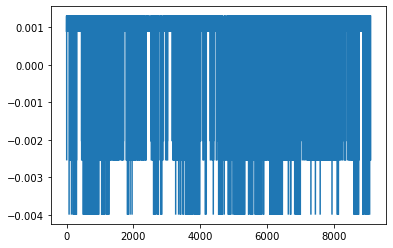

In [102]:
combined_df['β_O3_mean'].plot()

<AxesSubplot:>

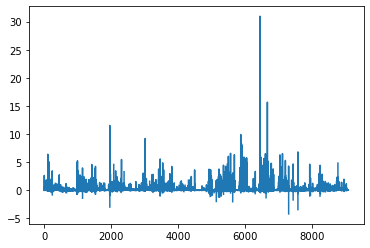

In [97]:
combined_df[f'Δmortality_O3_mean_nonuc']

## Additional Calculations

In [42]:
#createa a geodataframe
geometry_df = combined_df.groupby(
    ['County_State','Race/Hispanic Origin','nuclear_containing']).first()

In [43]:
#calculate the mortalities/population
for sub in ['_mean', '_low', '_high']:
    for run in ['nonuc','nonuc_coal','renew_nonuc']:
        combined_df[f'Δmortality_O3{sub}_{run}_per1mil'] = combined_df[f'Δmortality_O3_mean_{run}']/combined_df['Population']*1e6
        combined_df[f'Δmortality_PM{sub}_{run}_per1mil'] = combined_df[f'Δmortality_PM_mean_{run}']/combined_df['Population']*1e6

In [44]:
final_df = combined_df.groupby(['County_State','Race/Hispanic Origin','nuclear_containing', 'coal_containing']).mean()

In [45]:
final_df = final_df.join(geometry_df['geometry'])

# Analysis

In [46]:
def grouped_weighted_avg(values, weights):
    return (values * weights).sum() / weights.sum()

## Total Mortalities by scenario and pollutant

In [47]:
for run in ['nonuc','nonuc_coal','renew_nonuc']:
    print(final_df[f'Δmortality_O3_mean_{run}'].sum())

1559.637562892105
3594.038120017524
-585.0711758093041


In [48]:
for run in ['nonuc','nonuc_coal','renew_nonuc']:
    print(final_df[f'Δmortality_PM_mean_{run}'].sum())

3868.523389754152
4416.622715614864
1068.7778866098681


## Exposure Difference by Coal Containing or Not

In [49]:
for run in ['nonuc','nonuc_coal']:
    print('Near', 'PM', run)
    print(grouped_weighted_avg(final_df.xs(True, level = 3)[f'PM25_{run}'].groupby('County_State').mean(), 
                     final_df.xs(True, level = 3)[f'Population'].groupby('County_State').mean()))
    print('Near', 'O3', run)
    print(grouped_weighted_avg(final_df.xs(True, level = 3)[f'O3_{run}'].groupby('County_State').mean(), 
                     final_df.xs(True, level = 3)[f'Population'].groupby('County_State').mean()))
    

Near PM nonuc
0.2231527793147156
Near O3 nonuc
0.6011060337174368
Near PM nonuc_coal
0.19335954828644286
Near O3 nonuc_coal
1.0756018209801794


### Mortality Difference by Coal County

In [50]:
for run in ['nonuc', 'nonuc_coal']:
    print(run)
    print('PM, near: ', (final_df.xs(True, level = 3)[f'Δmortality_PM_mean_{run}'].sum()/final_df.xs(True, level = 3)['Population'].sum())*1e6)
    print('PM, not: ', (final_df.xs(False, level = 3)[f'Δmortality_PM_mean_{run}'].sum()/final_df.xs(False, level = 3)['Population'].sum())*1e6)
    print('O3, near: ', (final_df.xs(True, level = 3)[f'Δmortality_O3_mean_{run}'].sum()/final_df.xs(True, level = 3)['Population'].sum())*1e6)
    print('O3, not: ', (final_df.xs(False, level = 3)[f'Δmortality_O3_mean_{run}'].sum()/final_df.xs(False, level = 3)['Population'].sum())*1e6)

nonuc
PM, near:  11.84080694785532
PM, not:  8.440731404457427
O3, near:  4.05466808010775
O3, not:  3.580071156255379
nonuc_coal
PM, near:  11.158893817037958
PM, not:  10.217743839273284
O3, near:  7.034631784136795
O3, not:  8.818597245432203


## Exposure Difference by Nuclear or Not County

In [51]:
for run in ['nonuc','nonuc_coal','renew_nonuc']:
    print('PM25')
    print('Near', run)
    print(grouped_weighted_avg(final_df.xs(True, level = 2)[f'PM25_{run}'],
                  final_df.xs(True, level = 2)[f'Population']))
    print('Not', run)
    print(grouped_weighted_avg(final_df.xs(False, level = 2)[f'PM25_{run}'],
                  final_df.xs(False, level = 2)[f'Population']))
    print('O3')
    print('Near', run)
    print(grouped_weighted_avg(final_df.xs(True, level = 2)[f'O3_{run}'],
                  final_df.xs(True, level = 2)[f'Population']))
    print('Not', run)
    print(grouped_weighted_avg(final_df.xs(False, level = 2)[f'O3_{run}'],
                  final_df.xs(False, level = 2)[f'Population']))

PM25
Near nonuc
0.16085316566499183
Not nonuc
0.17030336802487214
O3
Near nonuc
0.4527071290304673
Not nonuc
0.4749086895126478
PM25
Near nonuc_coal
0.2761228469948298
Not nonuc_coal
0.18605981062121835
O3
Near nonuc_coal
1.4786084125261834
Not nonuc_coal
1.1262916515435022
PM25
Near renew_nonuc
0.05826114254362446
Not renew_nonuc
0.04364038074179068
O3
Near renew_nonuc
-0.19927701300164136
Not renew_nonuc
-0.2676053350909169


### Mortality Difference by Nuclear or Not Adjacent County

In [82]:
sub = 'mean'
for run in ['nonuc', 'nonuc_coal','renew_nonuc']:
    print(run)
    print('PM, near: ', utils.grouped_weighted_avg(final_df.xs(True, level = 2)[f'Δmortality_PM_{sub}_{run}_per1mil'], final_df.xs(True, level = 2)['Population']))
    print('PM, not: ', utils.grouped_weighted_avg(final_df.xs(False, level = 2)[f'Δmortality_PM_{sub}_{run}_per1mil'], final_df.xs(False, level = 2)['Population']))
    print('O3, near: ', utils.grouped_weighted_avg(final_df.xs(True, level = 2)[f'Δmortality_O3_{sub}_{run}_per1mil'], final_df.xs(True, level = 2)['Population']))
    print('O3, not: ', utils.grouped_weighted_avg(final_df.xs(False, level = 2)[f'Δmortality_O3_{sub}_{run}_per1mil'], final_df.xs(False, level = 2)['Population']))

nonuc
PM, near:  7.953206028357115
PM, not:  9.19446289905097
O3, near:  3.0597627101163787
O3, not:  3.7148720588351343
nonuc_coal
PM, near:  12.568515519625342
PM, not:  10.27784269256486
O3, near:  8.923313736839525
O3, not:  8.446745167567924
renew_nonuc
PM, near:  2.915640218838251
PM, not:  2.4962421760398077
O3, near:  -1.0491173116977073
O3, not:  -1.3988590870527966


## Plot the counties with Nuclear Plants near 

In [50]:
gen = feather.read_dataframe(f'../optimization_model/outputs/gen_normal.feather')
carac = pd.read_csv(f'../optimization_model/good_model_inputs/inputs_gen_normal.csv')
carac.loc[carac['FuelType'] == 'Pumps', 'FuelType'] = 'Hydro' #change pumps to hydro label
# Clean columns name
carac = carac.drop('Unnamed: 0', axis=1)

# Merge
df_normal = pd.concat((carac,gen), axis=1)
df_normal['2016_365_23'] = df_normal['2016_365_22'].copy()

col_list = list(gen.columns)
col_list.append('2016_365_23')
df_normal['total_gen'] = df_normal[col_list].sum(axis=1)

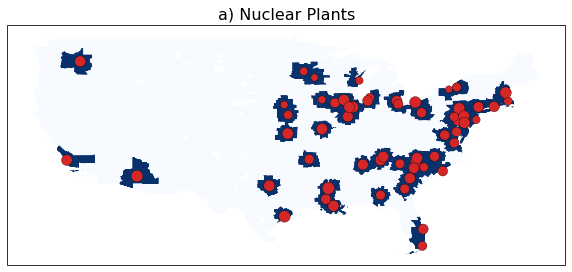

In [51]:
fig, ax = plt.subplots(figsize=[10,5], subplot_kw={'projection':ccrs.LambertConformal()})
mod_factor = 80000

###### Nuclear Plot ######

plants = ['Nuclear'] 

fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']


###### Create axes ######
ax.coastlines()
ax.add_feature(cfeat.STATES)
ax.set_title('a) Nuclear Plants', fontsize = 16)

###### plot #######
final_df.reset_index().plot(ax = ax, column = 'nuclear_adjacent', cmap='Blues' )


#create lat and lon 
lat_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LAT']
lon_o = df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['LON']
#color based on the fuel type
fuel_type=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).first()['FuelType']
#size based on generation
size=df_normal.loc[(df_normal['FuelType'].isin(plants))].groupby(['ORISCode']).mean()['total_gen']/mod_factor
#PCM parameters and plot for observations
PCM_o=ax.scatter(lon_o, lat_o, c='C3', s = size, linewidth=.3, marker = 'o', edgecolor = 'k', 
                  alpha = 1.)



## Overall Difference in Exposure by Race

In [64]:

for poll in ['PM25_nonuc','PM25_nonuc_coal','PM25_renew_nonuc','O3_nonuc','O3_nonuc_coal', 'O3_renew_nonuc']:
    print('\n', poll, '\n')
    for re in ['Black or African American', 'Asian or Pacific Islander',
        'Hispanic or Latino',
        'White','American Indian or Alaska Native']:
        print(re, grouped_weighted_avg(final_df.xs(re, level =1)[poll], 
                           final_df.xs(re, level =1)[f'Population']))


 PM25_nonuc 

Black or African American 0.19503819922698037
Asian or Pacific Islander 0.11091368764938761
Hispanic or Latino 0.09071379492804463
White 0.17106535862392414
American Indian or Alaska Native 0.0730553051391578

 PM25_nonuc_coal 

Black or African American 0.2683086679467005
Asian or Pacific Islander 0.13213376927376655
Hispanic or Latino 0.07289433667498586
White 0.18480819244854674
American Indian or Alaska Native 0.09057522281198503

 PM25_renew_nonuc 

Black or African American 0.060708032513728936
Asian or Pacific Islander 0.02649212689259441
Hispanic or Latino 0.01509850081214234
White 0.04376934632844536
American Indian or Alaska Native 0.0013580020654468295

 O3_nonuc 

Black or African American 0.5852592698554492
Asian or Pacific Islander 0.2687240334795328
Hispanic or Latino 0.22127639928947745
White 0.4739412118964731
American Indian or Alaska Native 0.21105176738477405

 O3_nonuc_coal 

Black or African American 1.8121629930491083
Asian or Pacific Islander 0.67

## Overall Difference in Mortality by Race

In [ ]:
print(re, np.round((((combined_df[f'Δmortality_{poll}_mean_{run}']*combined_df[re]/combined_df['TOT_POP']).sum()/combined_df[re].sum())*1e6),2),


In [87]:
run = 'nonuc'

In [88]:
(((combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White'][f'Δmortality_O3_{sub}_{run}'] * 
    combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White'][f'Population']/combined_df['Population']).sum()/
 combined_df.loc[combined_df['Race/Hispanic Origin'] == 'White'][f'Population'].sum())*1e6)


                           
                           
                           

8.778289546897435

In [93]:
CI = 'mean'
for re in ['Black or African American', 'Asian or Pacific Islander',
        'Hispanic or Latino',
        'White','American Indian or Alaska Native']:
    print(re)
    for run in ['nonuc','nonuc_coal','renew_nonuc']:
        print( run)
        #print('PM25: ', (final_df.xs(re, level = 1)[f'Δmortality_PM_{CI}_{run}'].sum()/
               #final_df.xs(re, level = 1)['Population'].sum())*1e6)
        #print((final_df.xs(re, level = 1)[f'Δmortality_O3_{CI}_{run}']).sum())
        #print('Ozone: ', (final_df.xs(re, level = 1)[f'Δmortality_O3_{CI}_{run}'].sum()/
              # final_df.xs(re, level = 1)['Population'].sum())*1e6)

       # print('test2', grouped_weighted_avg(final_df.xs(re, level =1)[f'Δmortality_O3_{CI}_{run}_per1mil'], 
                        #   final_df.xs(re, level =1)[f'Population']))
        
        print(utils.grouped_weighted_avg(combined_df.loc[combined_df['Race/Hispanic Origin'] == re][f'Δmortality_O3_{CI}_{run}_per1mil'],
                           combined_df.loc[combined_df['Race/Hispanic Origin'] == re]['Population']))

Black or African American
nonuc
6.267615159045576
nonuc_coal
19.592784963553196
renew_nonuc
-1.5976673694506531
Asian or Pacific Islander
nonuc
-2.0906796283147364
nonuc_coal
-5.266345779460239
renew_nonuc
2.4887162693643066
Hispanic or Latino
nonuc
-2.43832419152061
nonuc_coal
-4.82952499082363
renew_nonuc
4.544864323284467
White
nonuc
8.778289546897435
nonuc_coal
19.457282222772236
renew_nonuc
-4.3186104940908345
American Indian or Alaska Native
nonuc
-7.970506715469234
nonuc_coal
-27.68906513189725
renew_nonuc
18.592748951265403


### Number of People

In [74]:
for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    print(re, final_df.xs(re, level =1)['Population'].sum())

American Indian or Alaska Native 1775483.0
Asian or Pacific Islander 12171227.0
Black or African American 26526147.5
Hispanic or Latino 30832800.0
White 171983729.5


In [75]:
for re in ['American Indian or Alaska Native', 'Asian or Pacific Islander',
       'Black or African American', 'Hispanic or Latino',
        'White']:
    print(re, 100-(len(np.unique(final_df.xs(re, level = 1).reset_index()['County_State']))/len(np.unique(final_df.reset_index()['County_State'])))*100)

American Indian or Alaska Native 89.42903752039152
Asian or Pacific Islander 87.30831973898859
Black or African American 56.313213703099514
Hispanic or Latino 74.38825448613377
White 0.16313213703099905
